In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
import sys
sys.path.insert(0,"..")
from predict.prediction_batch import greedy_decode_batch
from predict.prediction_string import decode_seq_str, decode_interacively
import pdb
from model.loss import LossCompute
import os
from io_.info_print import printing
from model.seq2seq import LexNormalizer
from model.generator import Generator
from evaluate.interact import interact
MAX_LEN = 100
script_dir = "."

INITIALIZING IMPORTS


In [2]:
#model_folder_starts_with = "f2f2-batchXdropout_char0.1-to_char_src-1_dir_sent-10_batch_size-model_18_aa04"
#model_folder_starts_with = "f178-DROPOUT_EVEN_INCREASE-0.1-to_sent+word+bridge_out-model_3_046c"
#model_folder_starts_with = "8ce6b-extend_ep-get_True-attention_simplifiedXauxXdropout0.1_scale_aux-True_aux-0.1do_char_dec-True_char_src_atten-model_14_ad6c"
#model_folder_starts_with = "a5c77"
#model_folder_starts_with = "fef8-new_data-batchXdropout_char0-to_char_src-1_dir_sent-10_batch_size-model_2_51a5"
#model_folder_starts_with = "e3900-liu-attention+unrolling0.2-to_char_src-1_dir_sent-15_batch-dir_word_src_1-unrolling_word_True-char_src_attention_False-model_2_14c2"
#model_folder_starts_with = "e3900-liu-attention+unrolling0.2-to_char_src-1_dir_sent-15_batch-dir_word_src_1-unrolling_word_True-char_src_attention_True-model_3_1a3"
#model_folder_starts_with ="8ce6b"
#model_folder_starts_with = "8e628"
#model_folder_starts_with = "84736"
#model_folder_starts_with = "84736-84736-SENT_context-get_True-attention_simplifiedXdrop_out_charXdir_word1dir_word-False_aux-0do_char_dec-True_char_src_atten-model_10_b59b"
#model_folder_starts_with = "84736-84736-SENT_context-get_True-attention_simplifiedXdrop_out_charXdir_word1dir_word-False_aux-0do_char_dec-False_char_src_atten-model_9_bb70"
model_folder_starts_with = "b9e49-aux_report+dense+ponderatipn+no_bucketing100-dense_dim_auxilliary0.001weight_binary_loss0.2-to_char_src-1_dir_sent-10_batch-dir_word_src_1-unrolling_word_True-char_src_attention_False-model_9_0f05"
#model_folder_starts_with = "97068_rioc-b91d7-aux-again-biggerREPLICATE-replicate1-2dir_word-None_aux-model_19_fb56"
#model_folder_starts_with = "97079_rioc-ef365-ATTbest-scale-2-True-25dir_word_encoder-all_context-att2-model_1_cade"
#model_folder_starts_with = "97077_rioc-ee386-REP_-replicate1-1dir-scale_1-model_15_f19e"
#model_folder_starts_with = "97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_word-model_4_76a1"
#model_folder_starts_with = "97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_sent-model_2_7d92"
#model_folder_starts_with = "97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_word-model_4_76a1"
#model_folder_starts_with = "97184_rioc-0cc46-ATTstandart_passing-with_att-dir_2-X-context_all-stable_decoding_state-init_context_decoder_False-model_4_2ffa"
#model_folder_starts_with = "97221_rioc-3e4f2-ATTattentionXauxXcont-big-teacher-with_att-dir_2-X-context_word-stable_decod-init_con_False-teacher_forceprop10_True-model_4_c551"
#model_folder_starts_with = "97221_rioc-3e4f2-ATTattentionXauxXcont-big-teacher-with_att-dir_2-X-context_all-stable_decod-init_con_False-teacher_forceprop10_True-model_2_7673"
#model_folder_starts_with = "97555_rioc--ATTword_vs_char-scale2-sha_context_all-auxnorm_not_norm_True-word_de_False-model_6_c253-folder"
#model_folder_starts_with = "97555_rioc--ATTword_vs_char-scale2-sha_context_all-auxnorm_not_norm_True-word_de_True-model_5_72ee-folder"
model_folder_starts_with = "97184_rioc-0cc46-ATTstandart_passing-with_att-dir_2-X-context_all-stable_decoding_state-init_context_decoder_False-model_4_2ffa"
model_folder_starts_with = "97679_rioc--ATTmodel_10-model_10_b22f-folder"
model_folder_starts_with = "4e128-WARMUP-unrolling-False0-model_1-model_1_1660-folder"
model_folder_starts_with = "97734_rioc--DEBUG-2LSMT-2dense0-model_3-model_3_88a4-folder"
#model_folder_starts_with = "97734_rioc--DEBUG-2LSMT-2dense0-model_1-model_1_413f-folder"
#model_folder_starts_with = "97734_rioc--DEBUG-2LSMT-2dense0-model_2-model_2_7a98"
model_folder_starts_with = "97793_rioc--DEBUG_NO_LOSS_PADDING-2LSMT-2dense0-model_1-model_1_b872-folder"
model_folder_starts_with = "97823_rioc--DEBUG_NO_LOSS_PADDING-LEAKY-2LSMT-2dense-5DROPOUT00-model_1-model_1_60d8-folder"


# model word context char decode no attn 
#model_folder_starts_with = "97942_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_767d-folder"
model_folder_starts_with = "98349_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_6249-folder"
model_folder_starts_with = "98759_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_b108-folder"
model_folder_starts_with = "99428_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_8fb8-folder"
#model_folder_starts_with = "99428_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_8fb8-start_3_ep-X1-train_longer"
model_folder_starts_with = "99428_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_8fb8-folder"
#"98759_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_b108-folder"
model_folder_starts_with = "99733_rioc--DEBUG_NO_LOSS_PADDING-0-model_3-model_3_ccda-folder"
model_folder_starts_with =  "99731_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_6cf0-folder"
#model_folder_starts_with = "99733_rioc--DEBUG_NO_LOSS_PADDING-0-model_4-model_4_5ce2-folder"
model_folder_starts_with = "100147_rioc--DEBUG_NO_LOSS_PADDING-0-model_1-model_1_8b89-folder"
# fake words only char2char
#model_folder_starts_with = "EU"
model_folder_starts_with = "9096728-B0-model_1-model_1_59a7-folder"
model_folder_starts_with = "9088021_rioc--B0-model_1-model_1_9fe6-folder"
model_folder_starts_with = "30e60-B0-model_1-model_1_780d"

In [3]:
# list all models folder that starts with model_folder_starts_with
list_all_dir = os.listdir("../checkpoints/")
list_ = [dir_ for dir_ in list_all_dir if dir_.startswith(model_folder_starts_with) and not dir_.endswith("log") and not dir_.endswith("summary")]
print(list_)

['30e60-B0-model_1-model_1_780d-folder']


### Model to interact with 

#### Former models : trained on Liu only , source added as concatanation of word and sentence level as h_0 of decoder , batch size = 10 , small drop out , 

- f2f2-batchXdropout_char0.1-to_char_src-1_dir_sent-10_batch_size-model_18_aa04 : very bad at interacting (NB ; pb of eval)
- f178 also good model trained on liu only 
- 8e628 : attention ; no aux (no bucket , get_batch False ) :  - attention degrades abit the results (still feedin char embedding also)
- e390 + same 24f94 goo : 
    - best is e3900-liu-attention+unrolling0.2-to_char_src-1_dir_sent-15_batch-dir_word_src_1-unrolling_word_True-char_src_attention_False-model_2_14c2 
    - same with attentin but lame : e3900-liu-attention+unrolling0.2-to_char_src-1_dir_sent-15_batch-dir_word_src_1-unrolling_word_True-char_src_attention_True-model_3_1a3f (have to do some code for reloading and visulizing !)

#### New data 
- fef8_new_data : 
- mixed data+ aix test :  8d9a0 + b9e49 to compare bucketing impact at train time 
    - /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/aux_report+dense+ponderatipn+bucketing-last-report-data.html or file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/aux_report+dense+ponderatipn+bucketing-last-report-norm.html
    - /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/aux_report+dense+ponderatipn+no_bucketing-last-report-data.html or file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/8d9a0-auxiililary_true_false.html
    
    
- Auxilliary tuning : best model : b9e49-aux_report+dense+ponderatipn+no_bucketing100-dense_dim_auxilliary0.001weight_binary_loss0.2-to_char_src-1_dir_sent-10_batch-dir_word_src_1-unrolling_word_True-char_src_attention_False-model_9_0f05-folderfile:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/aux_report+dense+ponderatipn+no_bucketing-last-report-enriched-auxilliary_task_norm_not_norm-dense_dim_view.html
-

#### Last two ablations with extending epoch + mix data + ablation on auxilliary task ponderation + attention or not  

- 8ce6b-extend_ep... 
    - super lame attention model (from ablation with all context)
    - the other one a bit better   
- a5c77 a bit better but still : no attention much better : cf. plot 

#### Smaller model + liu only 
- 84736 smaller model: still waiting for models : attention not helping 

NB : attention makes training 10 times slower  

In [4]:
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/ablation_DROPOUT_analysis.html # f178
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/ablation_DROPOUT_analysis_norm_view.html #f178
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/ablation_DROPOUT_analysis_2.html # f178 + aaad 

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2-batchXdropout_char-summary-norm_view.html
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2-batchXdropout_char-summary-data_view.html
# -- 
#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2_best+01880_reproduction-VAL_TRUE.html
##file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2-iterate+new_data-norm_view.html (different results with below ? get_batch due ?? )
##/Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2-batchXdropout_char-summary-norm_view.html 
## diffent from file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/f2f2_best+01880_reproduction-VAL_TRUE.html val True 
#--

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/liu-attention+unrolling-more-param.html #e390
#!open file:///Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/e390_best+24f9d-VAL_FALSE.html (e390 with Vale False 10 points above!! )

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/fef8_new_data.html (very good ?)

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/extend_ep-SENT_context-get_True-attention_simplifiedXauxXdropout-last+bucket_False_eval-get_batch_False.html

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/8ce6b-extend_ep-get_True-attention_simplifiedXauxXdropout.html

#!open /Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/reports/8e628-no_bucketing-get_batch_False-train-attention-last+bucket_False_eval-get_batch_False-report.json.html



--------------------------------Interatcing with new model--------------------------------
 30e60-B0-model_1-model_1_780d 


Loading dictionary from ./../checkpoints/30e60-B0-model_1-model_1_780d-folder/dictionaries 
Loading model with argument {'symbolic_root': True, 'dropout_input': 0.0, 'tasks': ['normalize'], 'hidden_size_sent_encoder': 24, 'shared_context': 'word', 'char_embedding_dim': 40, 'voc_size': 57, 'ponderation_normalize_loss': 1, 'batch_size': 2, 'lr': 0.005, 'weight_binary_loss': 0, 'sanity_test': {'loss': 0.014993029493319838, 'data': ['/Users/bemuller/Documents/Work/INRIA/dev/mt_norm_parse/env/../../parsing/normpar/data/lexnorm.integrated.demo']}, 'weight_pos_loss': 0, 'output_dim': 200, 'symbolic_end': True, 'proportion_pred_train': None, 'hidden_size_decoder': 300, 'word_voc_input_size': 48, 'hidden_size_encoder': 200, 'word_voc_output_size': None, 'checkpointing_metric': 'loss-dev-all', 'multi_task_loss_ponderation': {'normalize': 1, 'pos': 1, 'norm_not_norm': 0, 

DECODING scores tensor([[[-11.5573, -16.2208, -16.2157,   0.0863,  -6.3474,  -2.4294,
          -16.1233,  -4.0163,  -5.8089,  -4.4190,  -7.6537,  -7.4453,
           -5.3804, -16.2699,  -7.7042,  -7.1113,  -4.0443,  -7.9071,
          -16.4466,  -8.3288,  -3.7002, -11.3625, -10.2443,  -8.1781,
          -11.7849,  -8.5406,  -5.2836, -12.0604, -16.0918,  -5.6367,
          -12.6534, -11.2755, -16.4185,  -7.6010,  -5.7127, -12.1185,
          -10.5199, -16.4939, -16.4455, -13.7914, -12.7985,  -9.6151,
           -7.8439, -16.0710, -16.6201, -16.5570, -13.9858,  -6.0668,
          -16.0971, -16.0884, -16.2233, -16.3790, -16.0148, -16.6449,
          -16.3610,  -7.8317, -16.3984]],

        [[-18.0955, -28.4225, -28.4182, -13.1657,  -7.3605, -12.7107,
          -28.0428,  -9.5744, -11.9287, -11.1781, -11.6084,  -8.6302,
           -9.1820, -28.3702,  -7.7562, -12.7552,  -9.9204,  -8.6883,
          -28.3232,  -6.3736,  -9.9846, -17.5030, -13.8068,  -6.6372,
          -14.6236, -15.7492, -

Decoding step 1 decoded target ['_START _ROOT_CHAR _END_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START o k _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START _END _END_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START _ROOT_CHAR _END_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_

DECODING decoding_states tensor([[[ 1.5233e-01, -3.2691e-02,  1.5491e-02,  ..., -6.9684e-01,
          -8.5781e-02, -1.4163e-01],
         [ 1.1647e-02, -3.4988e-01,  5.1579e-01,  ..., -2.5207e-01,
          -6.8771e-02, -8.9835e-02],
         [-2.8030e-03,  2.7517e-01,  6.5601e-01,  ..., -2.2538e-01,
          -4.2154e-01, -2.7057e-04]],

        [[ 8.5259e-02,  2.8203e-02,  1.2002e-02,  ...,  6.1460e-01,
          -3.9502e-01,  7.9226e-02],
         [-9.8536e-02,  3.0363e-01,  6.4552e-01,  ...,  3.7292e-01,
           2.6021e-01,  5.5199e-02],
         [ 4.0705e-02,  7.2071e-01, -4.5040e-01,  ...,  5.5469e-01,
           3.4476e-01, -2.1338e-01]],

        [[ 7.6918e-02, -1.1356e-02,  1.2379e-02,  ...,  1.6900e-01,
          -9.5229e-02, -9.7820e-02],
         [-2.3560e-02, -6.2371e-01,  5.6190e-01,  ...,  8.6045e-02,
           9.4943e-03, -2.4913e-02],
         [ 4.7755e-02,  5.9979e-01,  4.4163e-01,  ...,  3.7574e-03,
          -3.1273e-01, -7.9424e-03]]])
Decoding step 3 decoded 

DECODING decoding_states tensor([[[ 1.5233e-01, -3.2691e-02,  1.5491e-02,  ..., -6.9684e-01,
          -8.5781e-02, -1.4163e-01],
         [ 1.1647e-02, -3.4988e-01,  5.1579e-01,  ..., -2.5207e-01,
          -6.8771e-02, -8.9835e-02],
         [-2.8030e-03,  2.7517e-01,  6.5601e-01,  ..., -2.2538e-01,
          -4.2154e-01, -2.7057e-04],
         [ 3.5691e-02,  3.2525e-01,  1.1177e-01,  ..., -2.2863e-01,
          -3.7504e-01,  1.0573e-01]],

        [[ 8.5259e-02,  2.8203e-02,  1.2002e-02,  ...,  6.1460e-01,
          -3.9502e-01,  7.9226e-02],
         [-9.8536e-02,  3.0363e-01,  6.4552e-01,  ...,  3.7292e-01,
           2.6021e-01,  5.5199e-02],
         [ 4.0705e-02,  7.2071e-01, -4.5040e-01,  ...,  5.5469e-01,
           3.4476e-01, -2.1338e-01],
         [ 1.2369e-01,  2.0452e-01, -3.6044e-02,  ...,  4.9201e-01,
          -4.4489e-01, -2.0041e-02]],

        [[ 7.6918e-02, -1.1356e-02,  1.2379e-02,  ...,  1.6900e-01,
          -9.5229e-02, -9.7820e-02],
         [-2.3560e-02, -6.

DECODING decoding_states tensor([[[ 1.5233e-01, -3.2691e-02,  1.5491e-02,  ..., -6.9684e-01,
          -8.5781e-02, -1.4163e-01],
         [ 1.1647e-02, -3.4988e-01,  5.1579e-01,  ..., -2.5207e-01,
          -6.8771e-02, -8.9835e-02],
         [-2.8030e-03,  2.7517e-01,  6.5601e-01,  ..., -2.2538e-01,
          -4.2154e-01, -2.7057e-04],
         [ 3.5691e-02,  3.2525e-01,  1.1177e-01,  ..., -2.2863e-01,
          -3.7504e-01,  1.0573e-01],
         [ 3.0379e-03,  8.3624e-02,  1.5201e-03,  ..., -5.3113e-02,
          -2.1904e-02,  3.3221e-01]],

        [[ 8.5259e-02,  2.8203e-02,  1.2002e-02,  ...,  6.1460e-01,
          -3.9502e-01,  7.9226e-02],
         [-9.8536e-02,  3.0363e-01,  6.4552e-01,  ...,  3.7292e-01,
           2.6021e-01,  5.5199e-02],
         [ 4.0705e-02,  7.2071e-01, -4.5040e-01,  ...,  5.5469e-01,
           3.4476e-01, -2.1338e-01],
         [ 1.2369e-01,  2.0452e-01, -3.6044e-02,  ...,  4.9201e-01,
          -4.4489e-01, -2.0041e-02],
         [ 6.6522e-02, -3.62

DECODING scores tensor([[[-11.5573, -16.2208, -16.2157,  ..., -16.3610,  -7.8317,
          -16.3984],
         [-19.8039, -28.8560, -29.0544,  ..., -29.0625, -14.7945,
          -29.1533],
         [ -7.8816, -12.6706, -12.8079,  ..., -13.0264,  -6.2655,
          -12.8533],
         ...,
         [-18.7745, -22.3867, -21.7596,  ..., -21.8834, -13.1244,
          -22.0035],
         [-21.2825, -32.7227, -32.8189,  ..., -32.8931, -24.3293,
          -32.4084],
         [-27.7819, -31.3823, -31.1002,  ..., -31.2221, -18.2092,
          -31.3638]],

        [[-18.0955, -28.4225, -28.4182,  ..., -28.0715, -13.8340,
          -28.2755],
         [-12.2314, -17.4610, -17.2441,  ..., -17.7048,  -9.0958,
          -17.6628],
         [-24.7295, -30.5367, -30.4777,  ..., -30.7624, -24.5141,
          -31.0342],
         ...,
         [-37.3614, -37.2646, -37.7393,  ..., -37.6595, -28.2516,
          -37.5998],
         [-13.7074, -14.5483, -14.6225,  ..., -14.6367,  -9.0806,
          -14.6450

Decoding step 8 decoded target ['_START _ROOT_CHAR _END_CHAR _END_CHAR e r e s d a _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START o k a y _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START _END _END_CHAR e r e s d a y _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START _ROOT_CHAR _END_CHAR _END_CHAR e r e s d a _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PA

DECODING decoding_states tensor([[[ 1.5233e-01, -3.2691e-02,  1.5491e-02,  ..., -6.9684e-01,
          -8.5781e-02, -1.4163e-01],
         [ 1.1647e-02, -3.4988e-01,  5.1579e-01,  ..., -2.5207e-01,
          -6.8771e-02, -8.9835e-02],
         [-2.8030e-03,  2.7517e-01,  6.5601e-01,  ..., -2.2538e-01,
          -4.2154e-01, -2.7057e-04],
         ...,
         [-1.8159e-03, -6.7746e-02,  6.6635e-01,  ...,  8.2994e-02,
          -1.5538e-01, -2.6348e-01],
         [-1.4248e-03,  4.1988e-01, -4.1426e-01,  ...,  8.1922e-02,
           1.2153e-01, -2.3655e-01],
         [-1.0079e-01,  7.4009e-02, -2.4483e-02,  ...,  2.0554e-01,
          -3.1530e-01, -5.7092e-02]],

        [[ 8.5259e-02,  2.8203e-02,  1.2002e-02,  ...,  6.1460e-01,
          -3.9502e-01,  7.9226e-02],
         [-9.8536e-02,  3.0363e-01,  6.4552e-01,  ...,  3.7292e-01,
           2.6021e-01,  5.5199e-02],
         [ 4.0705e-02,  7.2071e-01, -4.5040e-01,  ...,  5.5469e-01,
           3.4476e-01, -2.1338e-01],
         ...,


DECODING scores tensor([[[-11.5573, -16.2208, -16.2157,  ..., -16.3610,  -7.8317,
          -16.3984],
         [-19.8039, -28.8560, -29.0544,  ..., -29.0625, -14.7945,
          -29.1533],
         [ -7.8816, -12.6706, -12.8079,  ..., -13.0264,  -6.2655,
          -12.8533],
         ...,
         [-27.1215, -32.5457, -32.4669,  ..., -31.9913, -26.9344,
          -32.4714],
         [-37.2394, -36.5787, -36.9442,  ..., -36.8072, -26.8846,
          -36.7981],
         [-13.7079, -14.6492, -14.4895,  ..., -14.5689,  -8.6934,
          -14.7033]],

        [[-18.0955, -28.4225, -28.4182,  ..., -28.0715, -13.8340,
          -28.2755],
         [-12.2314, -17.4610, -17.2441,  ..., -17.7048,  -9.0958,
          -17.6628],
         [-24.7295, -30.5367, -30.4777,  ..., -30.7624, -24.5141,
          -31.0342],
         ...,
         [ -8.7756, -14.9147, -14.7789,  ..., -14.7318,  -4.4940,
          -14.5327],
         [ -8.7591, -15.1461, -15.0289,  ..., -14.9635,  -5.0197,
          -14.7195

Decoding step 13 decoded target ['_START _ROOT_CHAR _END_CHAR _END_CHAR e r e s d a y _END_CHAR _END_CHAR h a _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START o k a y _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START _END _END_CHAR e r e s d a y _END_CHAR h a h a _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START _ROOT_CHAR _END_CHAR _END_CHAR e r e s d a y _END_CHAR _END_CHAR h a _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-1|', '_

Decoding step 15 decoded target ['_START _ROOT_CHAR _END_CHAR _END_CHAR e r e s d a y _END_CHAR _END_CHAR h a h a _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START o k a y _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START _END _END_CHAR e r e s d a y _END_CHAR h a h a _END_CHAR p _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START _ROOT_CHAR _END_CHAR _END_CHAR e r e s d a y _END_CHAR _END_CHAR h a h a _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-1|', '_START o k a y _END_CHAR _END_CHAR _END_C

Decoding step 17 decoded target ['_START _ROOT_CHAR _END_CHAR _END_CHAR e r e s d a y _END_CHAR _END_CHAR h a h a _END_CHAR p _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START o k a y _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START _END _END_CHAR e r e s d a y _END_CHAR h a h a _END_CHAR p r o _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START _ROOT_CHAR _END_CHAR _END_CHAR e r e s d a y _END_CHAR _END_CHAR h a h a _END_CHAR p _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-1|', '_START o k a y _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHA

Decoding step 19 decoded target ['_START _ROOT_CHAR _END_CHAR _END_CHAR e r e s d a y _END_CHAR _END_CHAR h a h a _END_CHAR p r o _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START o k a y _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START _END _END_CHAR e r e s d a y _END_CHAR h a h a _END_CHAR p r o b a _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START _ROOT_CHAR _END_CHAR _END_CHAR e r e s d a y _END_CHAR _END_CHAR h a h a _END_CHAR p r o _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-1|', '_START o k a y _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_C

Decoding step 21 decoded target ['_START _ROOT_CHAR _END_CHAR _END_CHAR e r e s d a y _END_CHAR _END_CHAR h a h a _END_CHAR p r o b a _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START o k a y _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START _END _END_CHAR e r e s d a y _END_CHAR h a h a _END_CHAR p r o b a b l _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START _ROOT_CHAR _END_CHAR _END_CHAR e r e s d a y _END_CHAR _END_CHAR h a h a _END_CHAR p r o b a _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-1|', '_START o k a y _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END

Decoding step 23 decoded target ['_START _ROOT_CHAR _END_CHAR _END_CHAR e r e s d a y _END_CHAR _END_CHAR h a h a _END_CHAR p r o b a b l _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START o k a y _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START _END _END_CHAR e r e s d a y _END_CHAR h a h a _END_CHAR p r o b a b l y _END_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START _ROOT_CHAR _END_CHAR _END_CHAR e r e s d a y _END_CHAR _END_CHAR h a h a _END_CHAR p r o b a b l _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-1|', '_START o k a y _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END

Decoding step 25 decoded target ['_START _ROOT_CHAR _END_CHAR _END_CHAR e r e s d a y _END_CHAR _END_CHAR h a h a _END_CHAR p r o b a b l y _END_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START o k a y _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START _END _END_CHAR e r e s d a y _END_CHAR h a h a _END_CHAR p r o b a b l y _END_CHAR h a _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-0|', '_START _ROOT_CHAR _END_CHAR _END_CHAR e r e s d a y _END_CHAR _END_CHAR h a h a _END_CHAR p r o b a b l y _END_CHAR _PAD_CHAR _PAD_CHAR _PAD_CHAR|sent-1|', '_START o k a y _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _PAD_C

Decoding step 27 decoded target ['_START _ROOT_CHAR _END_CHAR _END_CHAR e r e s d a y _END_CHAR _END_CHAR h a h a _END_CHAR p r o b a b l y _END_CHAR h a _PAD_CHAR|sent-0|', '_START o k a y _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _PAD_CHAR|sent-0|', '_START _END _END_CHAR e r e s d a y _END_CHAR h a h a _END_CHAR p r o b a b l y _END_CHAR h a h a _PAD_CHAR|sent-0|', '_START _ROOT_CHAR _END_CHAR _END_CHAR e r e s d a y _END_CHAR _END_CHAR h a h a _END_CHAR p r o b a b l y _END_CHAR h a _PAD_CHAR|sent-1|', '_START o k a y _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _END_CHAR _PAD_CHAR|sent-1|', '_START _END _

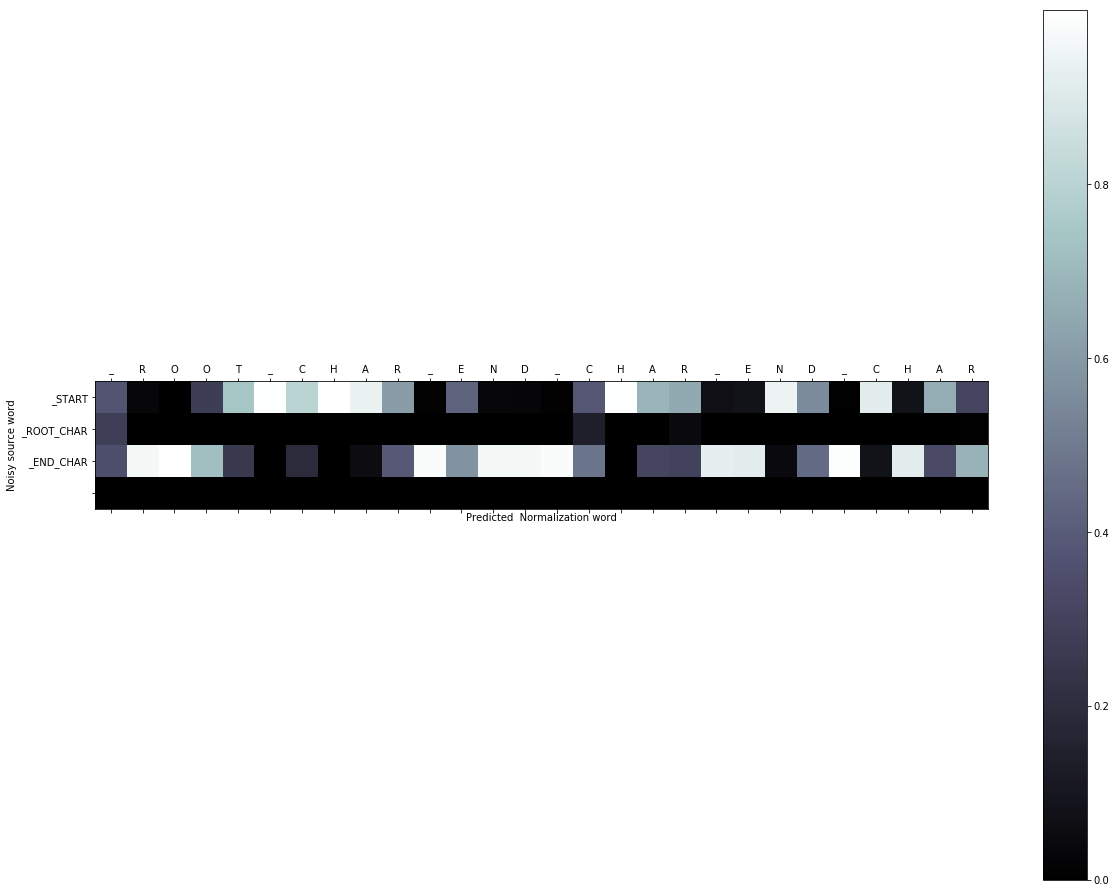

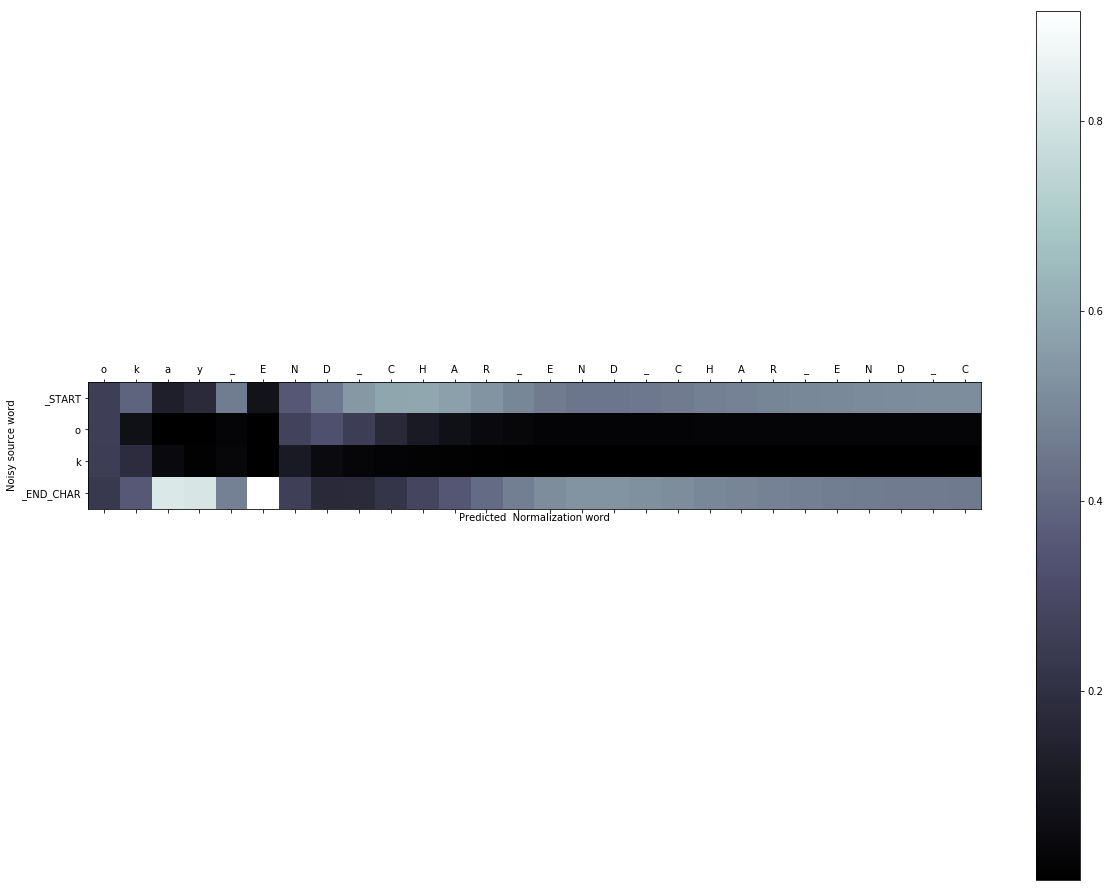

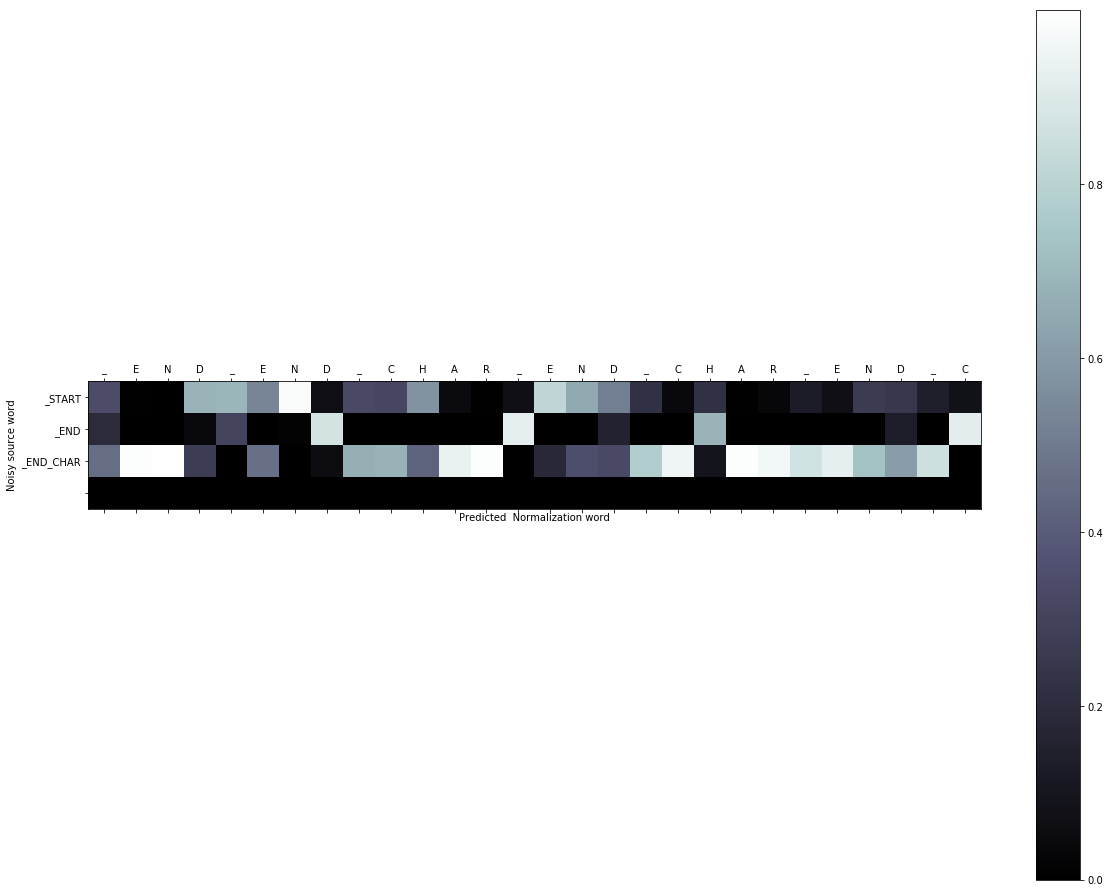

DECODED text is : ['_ROOT_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', 'okay_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR', '_END_END_CHAR_END_CHAR_END_CHAR_END_CHAR_END_CHAR'] original is ['_START_ROOT_CHAR_END_CHAR', '_STARTok_END_CHAR', '_START_END_END_CHAR'] and None seen as word embed 


In [ ]:
for folder_name in list_:
    assert len(list_)>0, "list empty"
    model_full_name = folder_name[:-7]
    print("\n\n--------------------------------Interatcing with new model--------------------------------\n", model_full_name,"\n\n")
    dic_path = os.path.join(script_dir, "..", "checkpoints", model_full_name + "-folder", "dictionaries")
    model_dir = os.path.join(script_dir, "..", "checkpoints", model_full_name + "-folder")
    interact(dic_path=dic_path, dir_model=model_dir, model_full_name=model_full_name, 
             debug=False, 
             show_attention=True, save_attention=False,
             extra_arg_specific_label="",max_len=30,
             verbose=0)
    #break

## Comments
- on model 97077_rioc-ee386-REP_-replicate1-1dir-scale_1-model_15_f19e with auxilliary task no attention quite small model
    - interesting case : 
        - my normalized to tomorrow : probably bcause of 2mor --> tommorow 
    - very lame at decoding very short word ? 
- 97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_word-model_4_76a1
    - attention is not static --> but no clear trend
    - interetsintgly with same model but only using sent context : the attention focus on last word all the time "97147_rioc-6ed16-ATTCONTEXT-with_att-dir_2-X-dropout_bridge0.1-context_sent-model_2_7d92" 
    
- "97184_rioc-0cc46-ATTstandart_passing-with_att-dir_2-X-context_all-stable_decoding_state-init_context_decoder_False-model_4_2ffa"
    - the best model you played with so far
    - classification does not agree with seq predictiion : most of the classification is NORMED while it performs some change

In [1]:
!open

Usage: open [-e] [-t] [-f] [-W] [-R] [-n] [-g] [-h] [-s <partial SDK name>][-b <bundle identifier>] [-a <application>] [filenames] [--args arguments]
Help: Open opens files from a shell.
      By default, opens each file using the default application for that file.  
      If the file is in the form of a URL, the file will be opened as a URL.
Options: 
      -a                Opens with the specified application.
      -b                Opens with the specified application bundle identifier.
      -e                Opens with TextEdit.
      -t                Opens with default text editor.
      -f                Reads input from standard input and opens with TextEdit.
      -F  --fresh       Launches the app fresh, that is, without restoring windows. Saved persistent state is lost, excluding Untitled documents.
      -R, --reveal      Selects in the Finder instead of opening.
      -W, --wait-apps   Blocks until the used applications are closed (even if they were already running).
  

In [ ]:
"./dat